# TFG Alberto Pampín

## Descripción del dataset

En primer lugar hay que realizar los imports necesarios:

In [82]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.preprocessing import MinMaxScaler


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [83]:
#csv_path = '../data/2_Oct2019.csv'
csv_path = '../data/historico_10_19_02_20.csv'
df = pd.read_csv(csv_path)

En este fichero se encuentran las mediciones que han realizado los sensores instalados en la ciudad de Santiago
de Compostela desde Octubre-2019 hasta Febrero-2020 (ambos incluidos).

**NOTA**: Al tratarse de un problema real las mediciones realizadas a partir de Marzo-2020 se han visto afectadas por
las restricciones sanitarias a causa del COVID-19, es por eso que no se tomarán en cuenta las mediciones a partir
de dicha fecha.

Ahora veamos cómo son los datos:

In [84]:
df.head()

,_id,speed,sensor,flow,FID,datetime
0,1,-9999,PM084,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
1,2,-9999,PM036,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
2,3,-9999,PM037,0,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
3,4,-9999,PM083,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
4,5,-9999,PM082,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00


Las columnas del dataset son las siguientes:
* `_id` (Integer): Identificador de la medición dentro del mes
* `speed` (Integer): NA
* `sensor` (String): Nombre del sensor que realizó la medición
* `flow` (Integer): Su valor entre 12 muestra el número de vehículos que pasaron sobre el sensor en los últimos 5 minutos
* `FID` (String): Identificador de la medición global -> PRIMARY KEY
* `datetime` (Timestamp): Fecha y hora en la que se tomó la medición.
Cada sensor inserta una nueva medición cada 5 minutos

In [85]:
df.shape

(2904410, 6)

Hay un total de **2904410 mediciones** y **6 columnas**.

Algunos datos interesantes sobre el dataset:

In [86]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_id,2904410.0,292897.638104,171773.694631,1.0,145221.0,290441.5,435662.0,638663.0
speed,2904410.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0


El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos:

<AxesSubplot:>

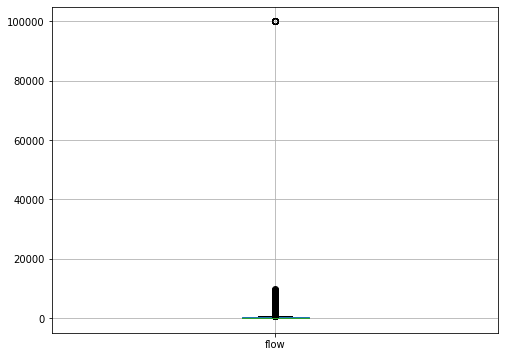

In [87]:
df.boxplot(column=['flow'])

In [88]:
bad_flow = df.loc[df['flow'] == 99999]
len(bad_flow)

31

Hay 31 mediciones con un valor erróneo para la columna `flow`: **Es necesario arreglar estos valores extremos!**

## Procesamiento del dataset

Algunos de los datos del dataset no interesan, bien porque su valor no es válido (`speed`) o bien porque
son simples identificadores (`_id` y `FID`). También se deberán formatear otras columnas:

In [89]:
df.pop('speed')
df.pop('FID')
df.pop('_id')

df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df.loc[:, 'flow'] // 12

df = df.sort_values(by='datetime')

In [90]:
df

,sensor,flow,datetime,car_count
0,PM084,12,2019-10-01 00:00:00,1
52,PM059,0,2019-10-01 00:00:00,0
51,PM017,48,2019-10-01 00:00:00,4
50,PM052,0,2019-10-01 00:00:00,0
49,PM016,48,2019-10-01 00:00:00,4
...,...,...,...,...
2758182,PM039,0,2020-02-29 23:55:00,0
2758181,PM074,0,2020-02-29 23:55:00,0
2758179,PM075,0,2020-02-29 23:55:00,0
2758186,PM024,48,2020-02-29 23:55:00,4


Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` es útil, pero es más interesante conocer el número de vehículos que
 pasaron sobre el sensor en los últimos 5 minutos: `car_count`
5. Se han ordenado todas las entradas por el campo `datetime`

Seleccionemos 5 mediciones al azar:

In [91]:
df.sample(n=5, random_state=12)

,sensor,flow,datetime,car_count
1649553,PM016,816,2019-12-26 10:40:00,68
1399995,PM061,0,2019-12-13 23:50:00,0
367447,PM015,624,2019-10-19 17:45:00,52
413484,PM077,18,2019-10-21 22:20:00,1
918679,PM033,0,2019-11-24 02:35:00,0


Veamos algunas estadísticas del conjunto de datos:

In [92]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0
car_count,2904410.0,12.309273,32.616128,0.0,0.0,4.0,19.0,8333.0


Como ya se comentó en la sección anterior, existen 31 outlayers claros ( valor 99999.0 en la columna `flow`) que deben
ser eliminados:

In [93]:
df = df[df['flow'] != 99999.0]
df = df[df['car_count'] != 8333.25]

Podemos ver que ya no hay ninguna fila con `flow == 99999.0`:

In [94]:
bad_flow = df.loc[df['flow'] == 99999.0]
len(bad_flow)

0

Revisando de nuevo las estadísticas del dataset:

In [95]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
flow,2904379.0,146.999220,216.285009,0.0,0.0,48.0,228.0,9672.0
car_count,2904379.0,12.220462,18.023441,0.0,0.0,4.0,19.0,806.0


<AxesSubplot:>

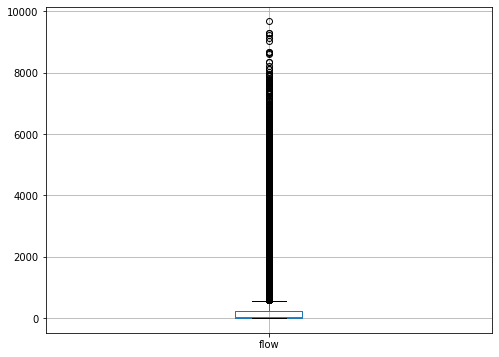

In [96]:
df.boxplot(column=['flow'])

A simple vista no se ven outlayers tan claros como anteriormente. Debido a que `flow` solo resulta de interés para
calcular `car_count`, esta característica puede ser eliminada ya del dataset.

In [97]:
df.pop('flow')

0          12
52          0
51         48
50          0
49         48
           ..
2758182     0
2758181     0
2758179     0
2758186    48
2758180     0
Name: flow, Length: 2904379, dtype: int64

## Experimentos planteados

Los experimentos a realizar consisten en predecir el tráfico en el punto en el que se ubica el
sensor `PM072` (CITIUS) en un instante `t` a partir de las mediciones realizadas por otros
sensores en un instante `t-x`. Los experimentos contemplados son los siguientes:

1. Predecir en `PM072` a partir de:
    - `PM029` (Entrada túnel Romero Donallo)
    - **No es posible, ya que ese sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)

2. Predecir en `PM072` a partir de:
    - `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
    - `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
    - `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - **No es posible, ya que ese sensor estaba averiado** -`PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

3. Predecir en `PM072` a partir de:
    - `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
    - `PM076` (Rúa do Horreo - Rotonda Galuresa)
    - `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
    - `PM079` (Rúa do Horreo - Rotonda Galuresa)

4. Predecir en `PM072` a partir de:
    - Todos los sensores disponibles

Para cada uno de los experimentos anteriormente citados se llevará a cabo la implementación del modelo con:
* Perceptrón multicapa
* Red Neuronal Convolucional (CNN)
* Red Neuronal Recurrente (RNN)

Asimismo, se deberá realizar un análisis de la varianza y bias para cada experimento
(Ver 6 primeras semanas Machine Learning Stanford: https://www.coursera.org/learn/machine-learning)

Por otra parte, también se probarán diversas formas de incluir las marcas temporales (timestamps) en el modelo:
* Día de la semana (1-7) y hora del día (minutos)
* Día de la semana y hora del día *modelado con sin y cos*
* Ventanas temporales (¿?)

## Experimento #1

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #1** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
* `PM029` (Entrada túnel Romero Donallo)
* **No es posible, ya que es sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)


### Análisis dataset Experimento #1
`
En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [98]:
sensors_list = ['PM029', 'PM072']
df_1 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [99]:
df_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_count,78690.0,16.797547,14.859483,0.0,4.0,13.0,26.0,92.0


Veamos un boxplot:

<AxesSubplot:>

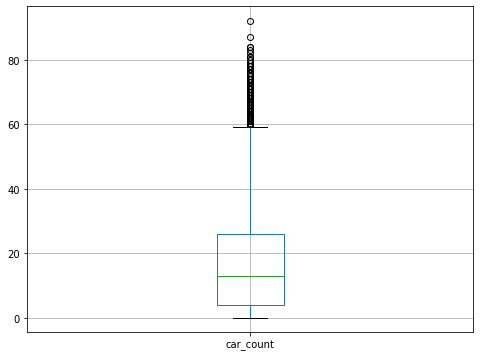

In [100]:
df_1.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`. Hay que tener en cuenta que los datos
que se encuentran fuera de la caja o de los brazos de la misma, no pueden ser considerados outlayers automáticamente.
Al tratarse de mediciones de tráfico, es evidente que a ciertas horas del día (principalmente de madrugada), el número de
coches registrado suele ser muy bajo incluso 0, por lo que la media y los cuartiles se encuentran afectados por estas
medicones.

### Análisis gráfico Experimento #1

Para ver la evolución de los datos del tráfico de manera más intuitiva se realizarán una serie de representaciones
gráficas.

La siguiente función recibe un dataframe, una lista de días y el nombre de un sensor. Grafica todas las mediciones
realizadas por ese sensor (agregados de 5 minutos) a lo largo de los días indicados

In [101]:
def plot_sensors_daily_data(df_orig, days_list, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    fig, axs = plt.subplots(days_list.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y)

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

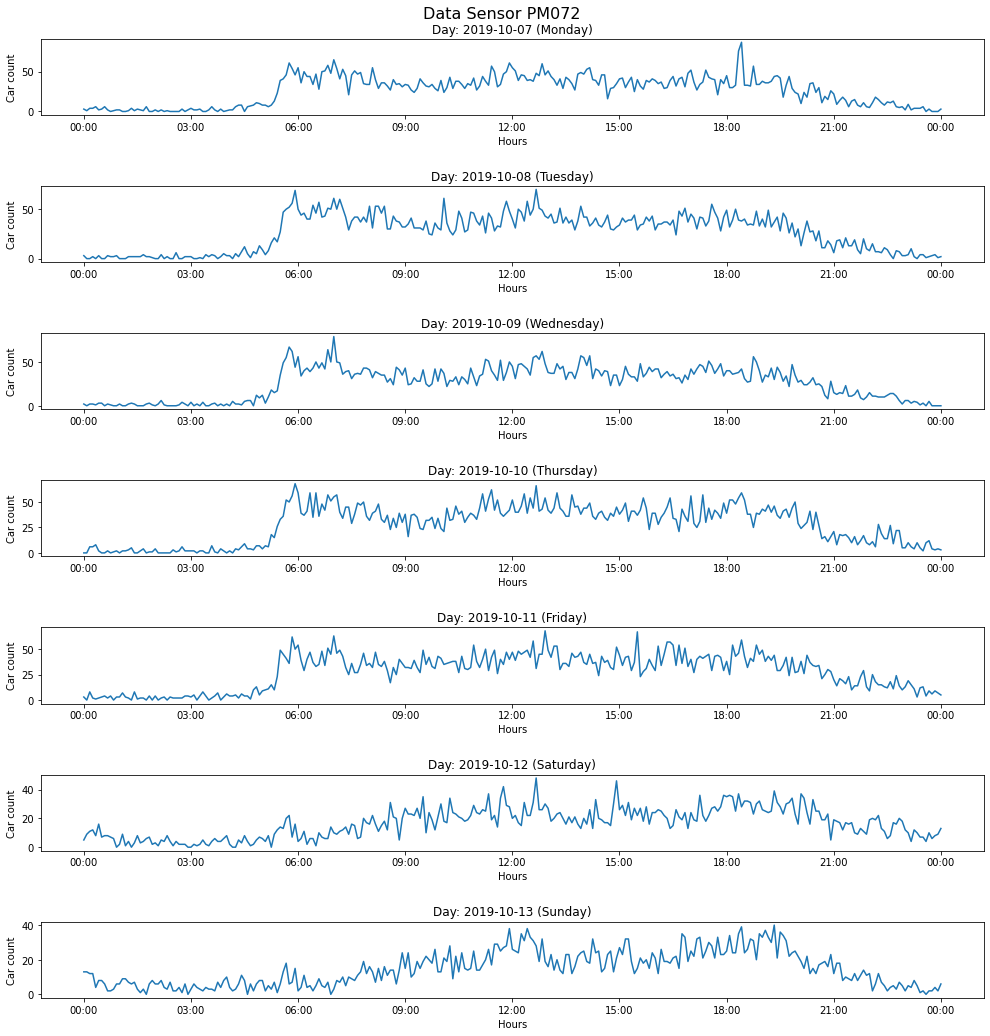

In [102]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

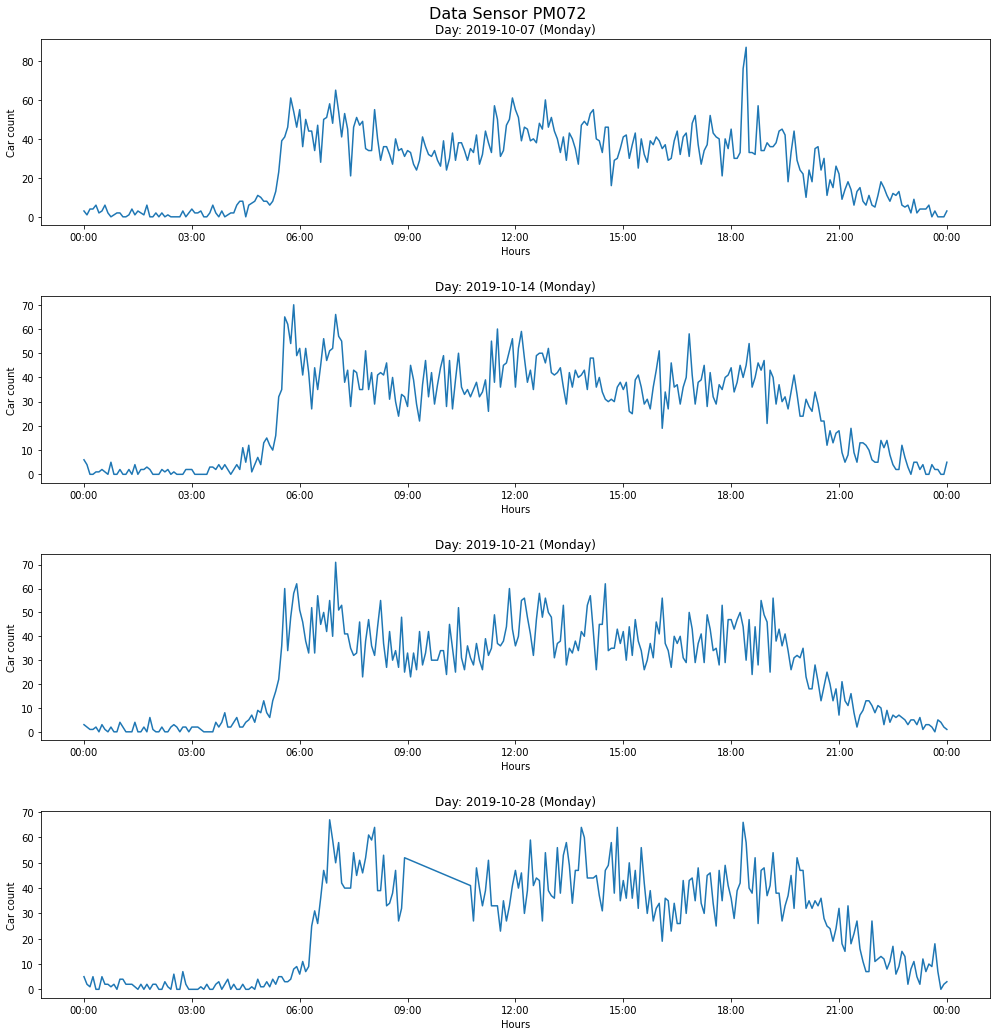

In [103]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

Las gráficas anteriores tienen mucho ruido, aunque resultan útiles para hacer una comprobación de outlayers.
Sin embargo, para ver de una manera más directa si existe periodicidad en el tráfico es más interesante **representar
los datos con agregados superiores a 5 minutos**

La siguiente función recibe un dataframe, una lista de días, un valor `n` que indica el número de mediciones agregadas,
y el nombre de un sensor. Grafica la media (mean) y desviación típica (std) de las mediciones realizadas durante el sensor
durante esos días en **agregados de 5*n minutos**

In [104]:
def plot_sensors_agregated_daily_data(df_orig, days_list, n, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    # Dataframe con los agregados
    df_mean = pd.DataFrame(columns=df.columns)
    df_std = pd.DataFrame(columns=df.columns)

    for g, df_slice in df.groupby(np.arange(len(df)) // n):
        mean_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].mean()}
        df_mean = df_mean.append(mean_row, ignore_index=True)

        std_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].std()}
        df_std = df_std.append(std_row, ignore_index=True)

    fig, axs = plt.subplots(days_list.shape[0], figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y_mean = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']
        y_std = df_std.loc[(df_std['datetime'] >= days_list[i]) & (df_std['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))

        axs[i].plot(x, y_mean, label='mean')
        axs[i].plot(x, y_std, label='std')
        axs[i].legend(loc='upper left')

Veamos la evolución del tráfico (media y desviación típica) durante una semana con agregados de 30 minutos (5*6)

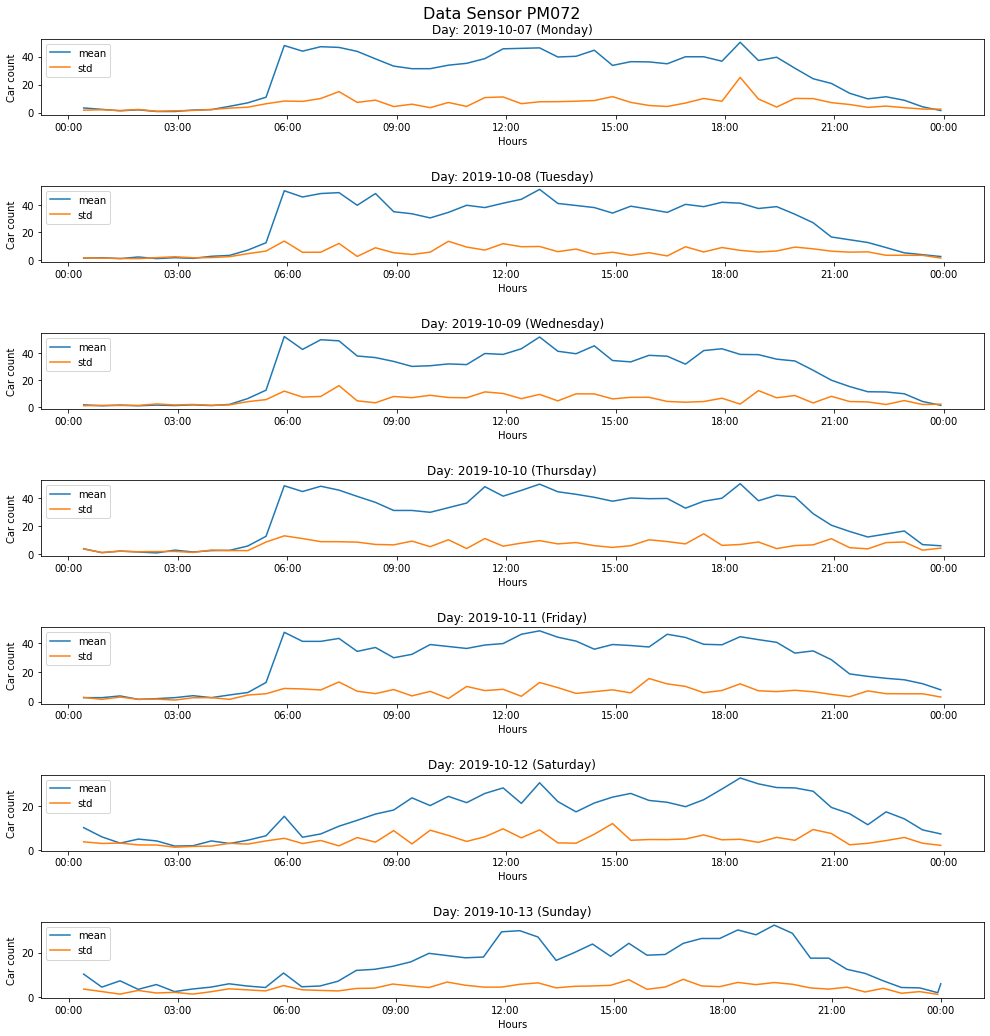

In [105]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

Veamos la evolución del tráfico durante los lunes de un mes con agregados de 30 minutos (5*6)

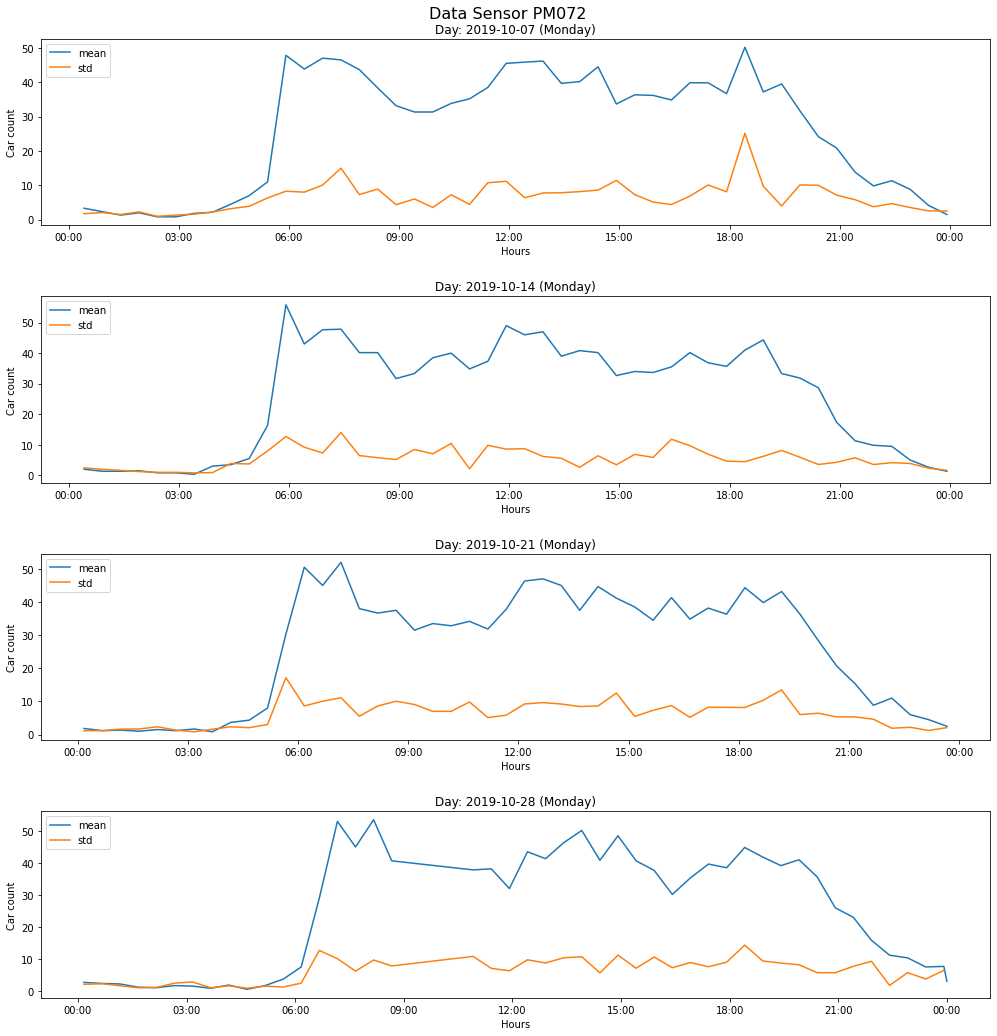

In [106]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')


### Preparación dataset Experimento #1

#### Label PM072

El objetivo del Experimento #1 es predecir el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS)
en un instante `t` a partir de las mediciones realizadas en un instante `t-x` por el sensor `PM029`.

A cualquier modelo es necesario pasarle un vector de características con el que pueda trabajar. En este caso, el vector
de características tiene la siguiente forma:

In [107]:
column_names = ['datetime', 'car_count_PM029', 'label_PM072']
pd.DataFrame(columns = column_names)

,datetime,car_count_PM029,label_PM072


Es decir, para cada instante temporal (`datetime`) que hay en el dataset, debe haber un vector de características que
contenga dicho instante temporal y el valor medido por los sensores que se usarán para predecir. Asimismo, también debe
contener el valor medido por el sensor `PM072` `x minutos` después.

Los sensores pueden fallar o detenerse por labores de mantenimiento, por lo que es posible que en algún instante temporal
uno de los sensores tome una medición y otro no, quedando así el vector de características incompleto. Esto no puede
permitirse, por lo que **si falta una medición de un sensor para un determinado instante temporal, todas las mediciones
correspondientes a dicho instante deben ser eliminadas.**

Para facilitar la preparación del dataset se ha creado la siguiente función. Recibe el dataset original, la lista de sensores
que se usarán para predecir, el sensor en el que se quiere predecir y los `x minutos` de desfase temporal.


In [108]:
def prepare_df(df_orig, sensors_list, label_sensor, x):

    # Instante temporal y car_count de dicho sensor
    prepared_df = df_orig.loc[ df_orig['sensor'] == sensors_list[0] , ['datetime', 'car_count']]
    # Renombrar la columna car_count
    prepared_df.rename(columns={'car_count': 'car_count_' + sensors_list[0]}, inplace=True)

    # INNER JOIN con los datos de cada sensor de la lista (sin contar el primero),
    # asi evito el problema de que falten mediciones de algunos sensores en un determinado instante temporal
    for ss in sensors_list[1:]:
        aux = df_orig.loc[ df_orig['sensor'] == ss, ['datetime', 'car_count']]
        aux.rename(columns={'car_count': 'car_count_' + ss}, inplace=True)
        prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    # Obtengo los datos del sensor a predecir x minutos despues
    aux = df_orig.loc[ df_orig['sensor'] == label_sensor, ['datetime', 'car_count']]
    # Resto los x minutos de para poder hacer el JOIN y MANTENIENDO EL CAR_COUNT que interesa
    aux['datetime'] = aux['datetime'] - datetime.timedelta(minutes=x)
    aux.rename(columns={'car_count': 'label_' + label_sensor}, inplace=True)
    prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    return prepared_df

A continuación se utiliza la función para preparar el dataset para el Experimento #1:

In [109]:
sensors_list = ['PM029']
df_1 = prepare_df(df_1, sensors_list, label_sensor='PM072', x = 5)

In [110]:
df_1.sample()

,datetime,car_count_PM029,label_PM072
25852,2020-01-11 15:05:00,9,35


#### Tiempo

Antes de construir un modelo es importante entender los datos con los que se trabaja y estar seguro que los datos
que se le pasan al modelo está correctamente formateados.

Observando ls gráficas anteriores se puede observar claramente que el tráfico tiene un comportamiento
cíclico según la *hora del día* y del *día de la semana*. Es decir, el tráfico de cada lunes durante todas las horas
del día es muy similar. A continuación se codificará este comportamiento:

#### Horas del día

Una de las formas más comunes para representar características cíclicas es mediante el uso de la función seno y la función
coseno [REFERENCIA]. En primer lugar, es necesario recuperar las horas y minutos de las fechas y convertirlo en segundos (o en minutos):

In [111]:
date_time = pd.to_timedelta(df_1['datetime'].dt.strftime('%H:%M:%S'))
date_time_s = date_time.dt.total_seconds().astype(int)

El tiempo en segundos no resulta muy útil como input para el modelo. Está claro que la periodicidad del tráfico es diaria.

Para convertir el tiempo en una señal usable se puede usar el seno y el coseno:

In [112]:
seconds_in_day = 24*60*60
df_1['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
df_1['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

De esta manera se logra modelar las horas como en un reloj, las 00h y están a continuación de las 23h.

La gráfica correspondiente al primer día del dataset es la siguiente ([:288] porque cada hora hay 12 mediciones * 24h = 288):

Text(0.5, 1.0, 'Time of day signal')

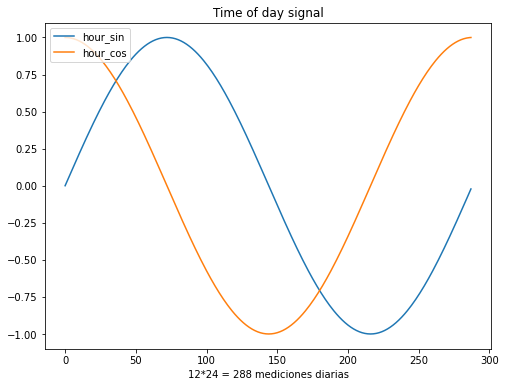

In [113]:
plt.plot(df_1[ 'hour_sin'][:288], label = 'hour_sin')
plt.plot(df_1['hour_cos'][:288], label = 'hour_cos')
plt.legend(loc='upper left')
plt.xlabel('12*24 = 288 mediciones diarias')
plt.title('Time of day signal')

Si solamente se observa la función seno, al trazar una línea horizontal se cruza en dos puntos, por lo que sólo teniendo
en cuenta esta característica, las 00:00h y las 12:00h son lo mismo. Para solucionar esto se toma en consideración el coseno, con ambas
características ya esposible distinguir esas horas y todo codificado de manera cíclica.

Una forma más intuitiva de ver lo que acabamos de hacer es representar ambas características como si se tratase un reloj:

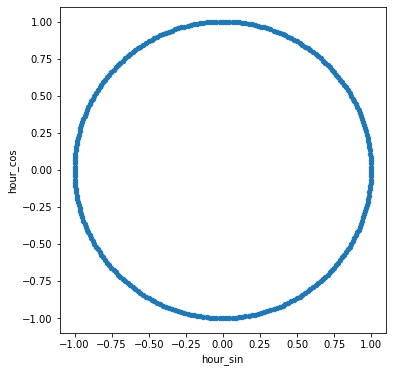

In [114]:
df_1[:288].plot.scatter('hour_sin','hour_cos').set_aspect('equal');

**Comentario personal:** Fíjate en las tablas a continuación que, evidentemente,
hour_sin` y  `hour_cos` son iguales para 2019-10-01 00:00:00 y 2019-10-02 00:00:00.
Como nos interesa que también se tenga en cuenta el día de la semana tenemos que hacer algo más!!

In [115]:
df_1[:2]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos
0,2019-10-01 00:00:00,1,0,0.000000,1.000000
1,2019-10-01 00:05:00,0,0,0.021815,0.999762


In [116]:
df_1[288:290]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos
288,2019-10-02 00:00:00,1,2,0.000000,1.000000
289,2019-10-02 00:05:00,1,4,0.021815,0.999762


#### Días de la semana

Tal y como hemos visto en las gráficas durante el `Análisis gráfico`, el tráfico tiene una clara frecuencia semanal.
Se puede ver cómo las gráficas de cada uno de los lunes (por ejemplo) son muy similares. Esto es algo que nos interesa
que nuestro modelo conozca, por lo que tenemos que realizar un trabajo similar al que hemos realizado con las horas.
*Los días de la semana también son cíclicos!*

In [117]:
wday = df_1['datetime'].dt.weekday
days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
df_1['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
df_1['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

Nuevamente, en una representación circular, vemos los 7 días de la semana:

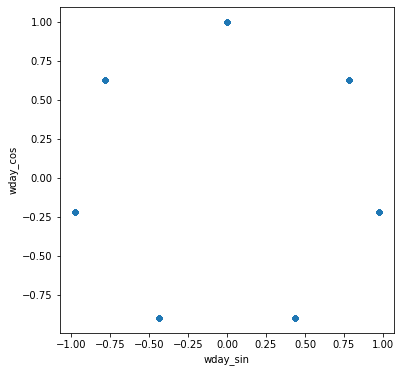

In [118]:
df_1.plot.scatter('wday_sin','wday_cos').set_aspect('equal');

**Comentario personal:** Cada uno de los 7 puntos que vemos contiene 288 puntos (hay 288 mediciones cada día).
En la siguiente tabla podemos ver como cada día de la semana (del 0 al 6) tiene un `wday_sin` y `wday_cos` diferente!!

In [119]:
df_1[0:2000:288]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos,wday_sin,wday_cos
0,2019-10-01 00:00:00,1,0,0.000000,1.000000,0.781831,0.623490
288,2019-10-02 00:00:00,1,2,0.000000,1.000000,0.974928,-0.222521
576,2019-10-03 00:00:00,0,1,0.000000,1.000000,0.433884,-0.900969
864,2019-10-04 13:50:00,18,50,-0.461749,-0.887011,-0.433884,-0.900969
1152,2019-10-05 13:50:00,5,15,-0.461749,-0.887011,-0.974928,-0.222521
1440,2019-10-06 13:50:00,10,12,-0.461749,-0.887011,-0.781831,0.623490
1728,2019-10-07 13:50:00,17,49,-0.461749,-0.887011,0.000000,1.000000


#### Características auxiliares/extra

Durante la preparación se utilizaron/crearon columnas extra en el dataset que no aportarán nada a nuestro modelo.
Estas deben ser eliminadas antes del entrenamiento.

(Se mantienen para facilitar la graficación posterior)

#### Dataset final para Experimento #1

Finalmente el dataset contiene:
1. `datetime`: Fecha y hora de la medición
2. `car_count_PM029`: Número de coches que pasaron por el sensor en los últimos 5 minutos
3. `label_PM072`: El dato a predecir
4. `hour_sin` y `hour_cos`: Hora del día codificada
5. `wday_sin` y `wday_cos`: Día de la semana codificado


Para facilitar los siguientes experimentos se ha creado la función `encode_time_sin_cos`, que hará lo comentado anteriormente:

In [120]:
def encode_time_sin_cos(enc_df):

    date_time = pd.to_timedelta(enc_df['datetime'].dt.strftime('%H:%M:%S'))
    date_time_s = date_time.dt.total_seconds().astype(int)

    seconds_in_day = 24*60*60
    enc_df['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
    enc_df['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

    wday = enc_df['datetime'].dt.weekday
    days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
    enc_df['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
    enc_df['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

    # Se mantiene para graficar más tarde, debe ser eliminado antes de entrenar
    #enc_df.pop('datetime')

    return enc_df

def encode_time(enc_df):

    enc_df['week_day'] = enc_df['datetime'].dt.weekday
    enc_df['hour'] = enc_df['datetime'].dt.hour
    enc_df['min'] = enc_df['datetime'].dt.minute

    enc_df.pop('datetime')

    return enc_df

#### División del dataset

Es necesario dividir el dataset en los conjuntos de:
* Entrenamiento: `90%`
* Validación: `10%` (Dentro del de Entrenamiento)
* Test: `10%`

**Para evitar problemas con la distribución de las mediciones es necesario hacer un `shuffle`
(reordenamiento aleatorio del dataset) antes de dividirlo.**

In [121]:
# Shuffle
df_1=df_1.sample(frac=1).reset_index(drop=True)

n = len(df_1)
train_df_1 = df_1[0:int(n*0.90)]
test_df_1 = df_1[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1.pop('datetime')
test_dates = test_df_1.pop('datetime')

#### Separación de las 'features' y 'labels'

Debemos separar las características del dato a predecir (`label_PM072`) en ambos conjuntos:

In [122]:
train_labels = train_df_1.pop('label_PM072')
train_features = train_df_1

test_labels = test_df_1.pop('label_PM072')
test_features = test_df_1

#### Normalización de los datos

Normalizar los datos es un paso importante para lograr un buen modelo, ya que
ayuda a que el descenso de gradiente pueda converger de manera más rápida.

La normalización debe realizarse tras la `División del dataset` y **utilizando solamente los datos de conjunto
de entrenamiento.** Esto de sebe a que el conjunto de test juega el papel de datos que aún no han sido vistos,
usar información procedente de estos datos para la normalización de todo el conjunto daría lugar a un *sesgo*
durante la evaluación del desempeño del modelo.

In [123]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

### Implementación Perceptrón Multicapa

### Definición Perceptrón Multicapa (LUEGO EN LA MEMORIA VA EN OTRA SECCIÓN!!!)

El cerebro humano es un sistema sumamente complejo, no lineal y capaz de procesar información de forma paralela. A lo largo de
la historia, el ser humano ha tratado de replicar este funcionamiento mediante un modelo matemático, enseñando a un ordenador
a pensar y actuar como un humano en diferentes escenarios. Esta inspiración dio lugar a lo que hoy conocemos como redes
neuronales artificiales.

En [REFERENCIA Kevin Gurney] se define una red neuronal como prosigue: "Una red neuronal es una reunión interconectada
de elementos de procesamiento simple, *unidades* o *nodos*", cuya funcionalidad está basada en líneas generales en la
neurona animal. La habilidad de procesamiento de la red se almacena en las fuerzas, o *pesos*, de las conexiones entre
las unidades, obtenidas mediante un proceso de adaptación, o *aprendizaje*, de un conjunto de patrones de entrenamiento."

En la Figura [REFERENCIA Figura PERCEPTRÓN], se puede observar la representación comúnmente adoptada de la estructura básica de una
red neuronal, también conocida como *perceptrón*. El perceptrón recibe una o varias entradas, las cuales son ponderadas a
partir de unos *pesos*, y calcula la salida a través de una función de activación, concepto que se tratará más adelante.
[FIGURA PERCEPTRÓN]

Mediante la combinación de múltiples estructuras como la anteriormente mostrada, se puede crear una red neuronal más compleja,
conocida como *perceptrón multicapa*. La Figura [REFERENCIA Figura PERCEPTRÓN MULTICAPA] muestra un perceptrón multicapa
con una capa de entrada, una oculta y una de salida.
[FIGURA PERCEPTRÓN MULTICAPA]

En una red neuronal, las capas que se encuentran entre la capa de entrada y la de salida son conocidas como *capas ocultas*.
Las unidades que componen dichas capas ocultas se denominan *unidades ocultas*. En el anterior ejemplo, cada una de
estas unidades intermedias recibe el resultado de realizar la suma ponderada de cada una de las entradas y genera una salida
aplicando una función de activación. Asimismo, la capa de salida recibe la suma ponderada de los resultados producidos por cada
una de las unidades ocultas y genera la salida de la red aplicando una función de activación. Las ecuaciones correspondientes
al funcionamiento anteriormente descrito se muestran a continuación:
[ECUACIONES]

El perceptrón multicapa es la arquitectura más simple de red neuronal artificial. En secciones posteriores se tratarán otras
arquitecturas más complejas.

### Conceptos básicos

En esta sección se tratarán algunos de los conceptos básicos que son necesarios para la correcta comprensión
de lo expuesto más adelante.

#### Función de activación

La función de activación es la transformación que aplica una unidad a la entrada que recibe, añadiendo de esta manera
no-linealidad a la red, lo que permite que aprenda transformaciones complejas.

Caglar [REFERENCIA CAGLAR] define una función de activación como "una función g: R->R que es diferenciable casi en
cualquier punto". Algunas de las funciones de activación más utilizadas son:

* *Sigmoid*: [DEFINICIÓN].  Esta función aparece en la capa de salida y se usa para predecir probabilidad, ya que proporciona
valores comprendidos entre 0 y 1. Es muy común en problemas de clasificación binaria y modelado de regresiones logísticas [REFERENCIA Chigozie].

* *Hyperbolic Tangent (Tanh)*: [DEFINICIÓN]. Devuelve valores entre 1 y -1 con media cero, lo que ayuda al proceso de
*backpropagation*. Esta función se usa mayormente en problemas de procesamiento de lenguaje natural y
reconocimiento de voz [REFERENCIA Chigozie].

* *ReLU*: [DEFINICIÓN]. En [REFERENCIA BINB DING] se recoge un compendio de ventajas de esta función, entre las que cabe destacar:
    * Los cálculos realizados con ReLU son menos costosos que los de Sigmoid o Tanh, ya que no es necesario trabajar
    con funciones exponenciales.
    * Las redes neuronales que utilizan ReLu convergen más rápido en términos de tiempo de entrenamiento con descenso de gradiente.

La siguiente Figura muestra las funciones anteriormente comentadas:
[IMAGEN]

En conclusión, las funciones de activación son un pilar fundamental de las redes neuronales y deben seleccionarse en función
del problema que se afronte.

#### Función de coste

La función de coste es la función objetivo que se pretende minimizar durante el entrenamiento de la red.
Se encarga de medir la diferencia entre la salida real de nuestra red en un momento dado y la salida deseada.

La función más utilizada en problemas de regresión es la de *Error Cuadrático Medio (MSE)*, la cual mide la distancia entre la salida deseada y
la hipótesis y la eleva al cuadrado. La definición de dicha función es la siguiente: [DEFINICIÓN]


#### Forward Propagation

Se trata de las operaciones del conjunto de ecuaciones que permiten realizar los cálculos necesarios en las unidades de la red
para obtener una salida a partir de una determinada entrada. Estas ecuaciones ya han sido mostradas en el aparatado anterior.


#### Back Propagation

El entrenamiento de una red neuronal es un problema de optimización en el que se busca minimizar la función de coste.
Para ello se suele utilizar el algoritmo de Descenso de Gradiente [REFERENCIA SGD] junto con el de Backpropagation
[Rumelhart, D.E., Hinton, G.E., and Williams, R.J. (1986). “Learning representations by back-propagating errors”. Nature, vol.323, no 6088, pp. 533- 536.].
Este segundo algoritmo consiste en, como bien su nombre indica, retropropagar los errores cometidos en la salida, ajustando
así los pesos de las conexiones desde la última capa hasta la de entrada. Este algoritmo supuso un punto un punto de inflexión
en el campo de la Inteligencia Artificial, convirtiéndose en un elemento fundamental para el entrenamiento de redes neuronales.


#### Hiperparámetros

Los *hiperparámetros* son aquellos parámetros cuyo valor es utilizado para controlar el proceso de aprendizaje de una
red neuronal. En contraposición, se consideran *parámetros* de una red neuronal a los *pesos* de las conexiones, los
cuales se derivan durante el entrenamiento.

A continuación, se realiza un análisis de los principales hiperparámetros de la red:

* *Optimizador*: El *Descenso de Gradiente* es uno de los algoritmos más populares para llevar a cabo optimización y es
de largo el más utilizado para la optimización de redes neuronales [REFERENCIA SGD]. Existen tres variantes
de este algoritmo: el Stochastic, el Batch y el Mini-Batch, las cuales se diferencian en el número de ejemplos (*batch*)
que se utilizan para calcular el gradiente de la función objetivo antes de actualizar los parámetros:
    * *Batch gradient descent*: Utiliza todo el conjunto de entrenamiento antes de actualizar los parámetros.
    * *Stochastic gradient descent*: Actualiza los parámetros para cada ejemplo.
    * *Mini-batch gradient descent*: Actualiza los parámetros tras cada *n* ejemplos. Estos *n* ejemplos conforman el *mini-batch*

Existen mejoras de estos algoritmos como pueden ser el *Stochastic gradient descent with Momentum* o *Adam*.

* *Factor de aprendizaje*: El factor de aprendizaje o 'learning rate' es el parámetro que controla el ajuste de los pesos con respecto
a los gradientes; en otras palabras, modula el avance en la dirección opuesta al gradiente en cada actualización de parámetros
La elección de este hiperparámetro tiene un gran impacto en la calidad del modelo y en el tiempo requerido para el entrenamiento.
Un valor muy grande puede causar que no se llegue a la convergencia y un valor muy pequeño puede suponer un tiempo de entrenamiento
excesivo (en relación a la calidad del modelo resultante). La elección de un único valor del factor de aprendizaje es muy complejo
[REFERENCIA LEARNING RATE], por lo que en una sección posterior se detalla la metodología empleada.

* *Número de características de entrada*: Simplemente se trata del tamaño del vector que la red recibe en la entrada.

* *Número de capas ocultas y unidades por cada capa*: Tal y como se comentó en la introducción a las redes neuronales, se
pueden crear múltiples combinaciones variando el número de capas ocultas y unidades por cada capa. Dependiendo de la
arquitectura utilizada se obtendrán resultados diferentes.

* *Épocas*: Este hiperparámetro define el número de veces que el conjunto entero de datos ha sido mostrado a la red.
Una época indica que cada ejemplo, o conjunto de ejemplos si se trabaja con batches, ha tenido una oportunidad de actualizar
los parámetros internos. Generalmente, el rendimiento del sistema aumenta a medida que crece el número de épocas, hasta que alcanza
el punto máximo de mejora, conocido como óptimo de convergencia.

* *Función de coste y Función de activación*: Estos conceptos ya han sido descritos anteriormente en este trabajo, por lo que no se
entrará en más detalle en este apartado.

* *Dropout*: En [Referencia DROPOOUT] se define el Dropout como: "Una técnica que se utiliza para prevenir el overfitting
y proporciona una manera aproximada de combinar diferentes arquitecturas de redes neuronales de forma eficiente". Consiste
en "tirar" (drop) unidades de la red; es decir, descartar unidades junto con sus conexiones entrantes y salientes de forma temporal.
Esta técnica se puede aplicar en cada una de las capas de la red.
El Dropout se realiza de forma aleatoria, de tal manera que cada unidad es descartada con una probabilidad *p* independiente
de otras unidades. Un valor para la probabilidad *p* muy utilizado y que proporciona resultados satisfactorios en gran cantidad de tareas es 0.5,
lo que implica que se descartan la mitad de unidades de cada capa en la que se aplique.
La siguiente Figura muestra el resultado de aplicar el Dropout a una red de ejemplo:
[FIGURA DROPOUT]

* *Regularización de pesos:* Es otra técnica para prevenir el overfitting. En este caso se busca poner limitaciones a la complejidad
de la red forzando a que sus pesos tomen valores pequeños, siendo la distribución de pesos más *regular*. Para lograr esto
se añade una penalización a la función de coste asociada al uso de pesos grandes [REFERENCIA TNSFLW OVERFIT&UNDERFIT]. Existen dos tipos de regularización, L1 y L2.
La más usada es la L2, donde la penalización es proporcional al cuadrado de los pesos:
[FIGURA L2]
La constante *lambda* en la fórmula anterior modula la penalización que será aplicada a la función de coste.




#### Selección de hiperparámetros (Es parte del entrenamiento)

En esta sección se recoge la metodología empleada para la elección de los valores de los hiperparámetros de la red.
Algunos de ellos han sido modificados durante los diferentes experimentos, mientras que otros se han mantenido fijos.

En primer lugar, se indican los hiperparámetros que se han mantenido de forma fija y la justificación de por qué han sido elegidos:

* *Función de coste*: Como función de coste a minimizar se ha elegido el Error Cuadrático Medio (MSE). Se ha elegido
porque se trata de una de las funciones más utilizadas en problemas de regresión y que mejores resultados obtiene en general.
Además, también se monitoreará el Error Medio Absoluto (MAE) para tener dos funciones con las que poder realizar comparaciones
y extraer conclusiones.

* *Función de activación*: Por las ventajas expuestas anteriormente en este trabajo y por las listadas en [REFERENCIA ACtivarion],
se ha elegido la función ReLU como función de activación en cada capa oculta de la red. En la capa de salida no se
utiliza ninguna función de activación.

* *Optimizador*: Cuando se analizaron los hiperparámetros de una red neuronal se mencionaron tres variantes del algoritmo de
Descenso de Gradiente. Se ha seleccionado la variante Mini-batch gradient descent debido a que es la que aúna lo mejor de las
otras dos. Sin embargo, esta presenta una serie de retos, como puede ser la elección del Factor de aprendizaje [REFERENCIA SGD].
A raíz de esos retos han surgido algoritmos basados en el Descenso de Gradiente que tratan de solucionar algunos de ellos.
En la actualidad, uno de los optimizadores más comúnmente usados es el Adam (Adaptive Moment Estimation), el cual calcula
un factor de aprendizaje adaptativo para cada parámetro [Diederik P. Kingma and Jimmy Lei Ba. Adam: a Method for Stochastic Optimization. Interna- tional Conference on Learning Representations, pages 1–13, 2015.].
Debido a su amplio uso y sus ventajas, ha  sido el optimizador elegido para los experimentos realizados.

* *Número de características de entrada*: Dependiendo del experimento realizado el número de características de
entrada variará, ya que el número de sensores utilizado para la predicción será distinto.

Ahora es el turno de los hiperparámetros que han sido modificados. Determinar el valor óptimo de los hiperparámetros en
Machine Learning es un problema complejo [REFERENCIA HYPERPARAMs], que comúnmente se realiza de forma manual o siguiendo
una serie de reglas generales. Actualmente, existe una serie de aproximaciones a este problema que por su alta complejidad
han sido descartadas. Por este motivo, se ha decidido optar por la búsqueda de forma manual.

Debido a la gran cantidad de hiperparámetros y valores que estos pueden tomar, las combinaciones a la hora de crear una
red neuronal son prácticamente infinitas. Es por ello que se ha decidido seguir para la realización de cada experimento
la metodología propuesta en [REFERENCIA VIDEO SEBAS]. Esta metodología consta de las siguientes fases:

1. En la primera fase se establecerá una red con una combinación de hiperparámetros que servirá de línea base:

    - *Número de capas ocultas y unidades por cada capa*: Se comenzará con 2 capas ocultas y un número de
    unidades por capas dependiente de cada experimento.

    - *Tamaño del Mini-batch*: Al utilizar esta variante se debe indicar un tamaño para el mini-batch. La elección de este tamaño también
    es compleja y existen múltiples trabajos en los que se analiza el impacto que este hiperparámetro tiene sobre el modelo [REFERENCIA BATCH-SIZE].
    Generalmente, se utilizan tamaños entre 32 y 256, por lo que para comenzar se utilizarán 32 ejemplos para calcular
    el gradiente de la función objetivo antes de actualizar los pesos.

    - *Factor de aprendizaje*: Si bien el optimizador Adam calcula un factor de aprendizaje adaptativo para cada parámetro,
    es preciso indicar un valor inicial. Por defecto, la implementación del algoritmo en Keras lo fija en 0.001.

    - *Èpocas:* Se comenzará con 20 épocas.

2. Ahora hay que reducir el *bias* [REFERENCIA COURSERA ML STANFOR]; es decir, reducir el error en el conjunto
de entrenamiento. De esta manera la red aprenderá los patrones en los datos de entrenamiento. Para lograr esto se aplicarán
estas estrategias:
    - *Aumentar el número de capas y unidades por capa*
    - *Entrenar durante más tiempo (más épocas)*
    - *Modificar el factor de aprendizaje*
    - *Modificar el tamaño del mini-batch*

Esta fase se repetirá hasta que la red sea capaz de adaptarse de manera satisfactoria al conjunto de entrenamiento. En cuanto
sea así, se pasará a la tercera fase.

3. En esta fase hay que reducir la *varianza*; es decir, reducir el error en el conjunto de validación, evitando de esta manera
el *overfitting*. Para ello se aplicarán las dos técnicas comentadas anteriormente:
    - *Dropout*
    - *Regularización L2*

Las fases 2 y 3 se repetirán hasta lograr un modelo que cuento con un bias y varianza satisfactorios.
Este modelo será el seleccionado como *vencedor*.




#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**


In [124]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(256,
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(256,
                   activation='relu'),
      layers.Dense(256,
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [125]:
model = build_and_compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


In [126]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 9min 38s, sys: 1min 10s, total: 10min 48s
Wall time: 6min 20s


In [127]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
195,43.899643,4.868778,47.124306,5.028079,195
196,43.820229,4.865878,47.313583,5.071926,196
197,43.790462,4.861306,47.281464,5.032118,197
198,43.898083,4.869837,48.131683,5.099463,198
199,43.880295,4.866848,47.134346,5.054342,199


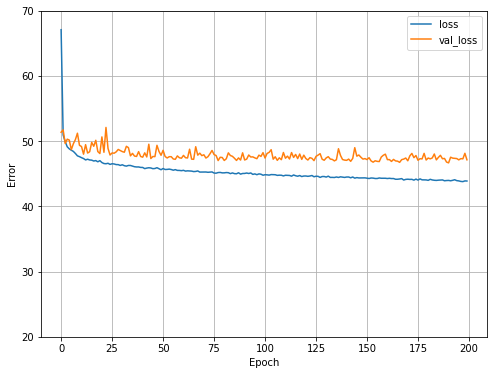

In [129]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


plot_loss(history)

In [136]:

predictions = pd.DataFrame(model.predict(test_features), columns = ['predictions'])
predictions

,predictions
0,5.595573
1,4.690495
2,28.410503
3,13.291266
4,38.405106
...,...
3874,15.687958
3875,6.303603
3876,34.127380
3877,34.789417


Tras haber realizado múltiples pruebas con las distintas arquitecturas e hiperparámetros, se ha llegado
a un modelo *vencedor*.

El MSE es una medida difícil de interpretar, ya que no está en las mismas unidades
que el problema. Por otra parte, el MAE es más fácil de interpretar, ya que este sí está en las mismas unidades.
Sin embargo, **este valor no es representativo.**

Tal y como se pudo observar en las gráficas del comienzo del trabajo,
hay determinadas horas del día en las que el número de coches es más bajo o más alto. Por ejemplo, entre las 00:00
y las 06:00 el número de coches es muy bajo, entre 5 y 10 (GENERALMENTE), mientras que en la franja de 06:00 a 18:00 
varía entre 30 y 50.

Decir que hay un error medio de 5 coches cuando pasan 60 coches es viable, no así si ese error se
da cuando pasan tan solo 2.

Para poder visualizar y comprender mejor la calidad del modelo se hará una representación gráfica a partir de los
resultados obtenidos en las predicciones con el conjunto de test. La siguiente función muestra una gráfica para cada
día de la semana en la que aparecen los datos reales y los predicho por el modelo.

**NOTA:** Cada gráfica contiene los resultados de un determinado día de la semana (p.ej, Lunes), pero ese día de la semana
puede corresponder a semanas/meses diferentes. Esto se hace para ver una representación más general, ya que no tendría
sentido representar las predicciones de cada fecha exacta.


In [192]:
def graph_predictions(test_dts, test_lbls, preds):
    # Concateno las fechas, los labels y las predicciones en el mismo df
    cc_df = pd.concat([test_dts, test_lbls], axis=1)
    cc_df.reset_index(inplace=True, drop=True)
    cc_df = pd.concat([cc_df, preds], axis=1)

    # Obtengo solo la hora de cada fecha
    cc_df['hour'] = cc_df['datetime'].dt.strftime('%H:%M:%S')

    # Obtengo el dia de la semana [0-Lunes, 6-Domingo]
    cc_df['wday'] = df_1['datetime'].dt.weekday

    # Ordeno por 'wday' y luego por 'hour' -> No es necesario
    cc_df = cc_df.sort_values(by=['wday', 'hour'])

    # Settings
    fig, axs = plt.subplots(7, figsize=(15,15))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Labels vs. Predictions', fontsize=16)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Gráfica para cada día de la semana
    for i in range(7):

        myFmt = mdates.DateFormatter('%H:%M')
        axs[i].xaxis.set_major_formatter(myFmt)
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title(day_names[i])

        # DataFrame para cada día de la semana
        aux = cc_df.loc[cc_df['wday'] == i]

        # Lista de horas que hay en el DataFrame para el día especificado por i
        x = aux['hour']

        # Para una determinada hora puede haber varios label y predicciones (#label == #preds)
        axs[i].plot(x, aux['label_PM072'], label='Labels')
        axs[i].plot(x, aux['predictions'], label='Predictions')
        axs[i].legend(loc='upper left')

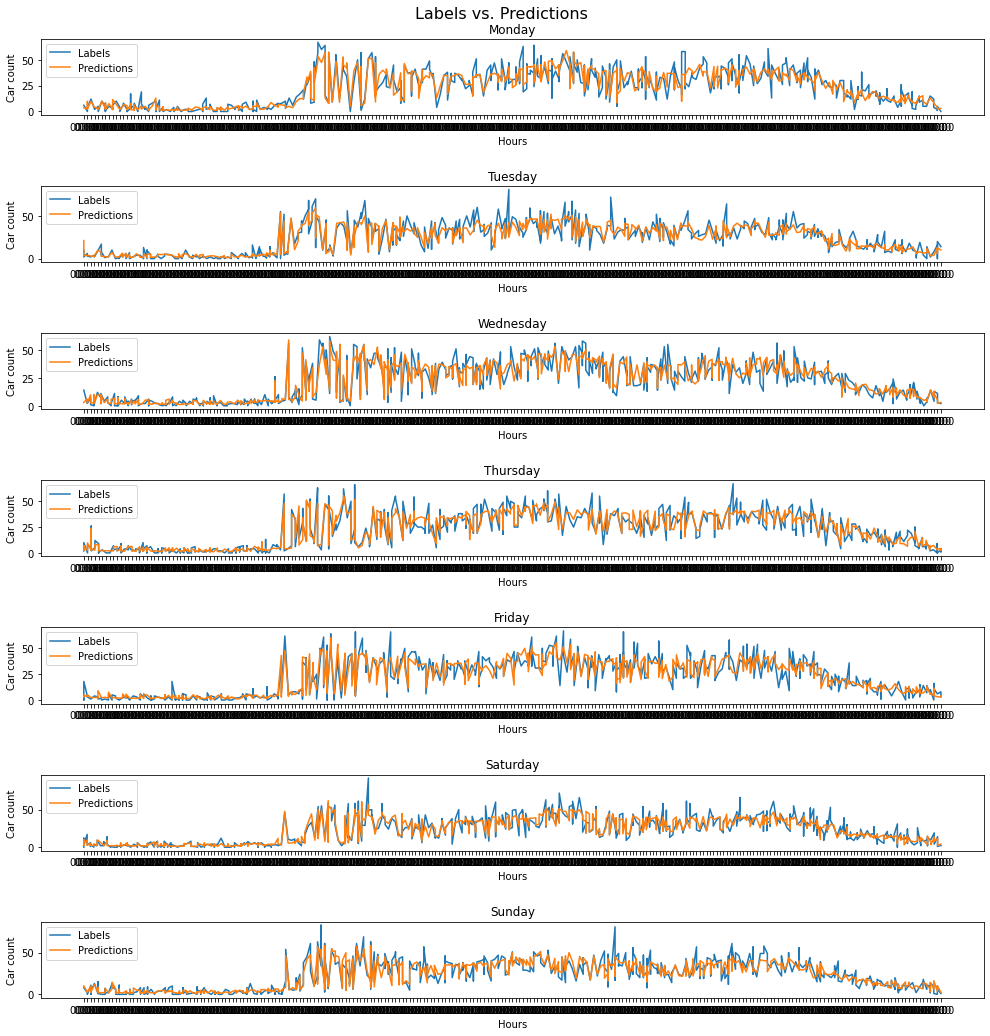

In [193]:
graph_predictions(test_dates, test_labels, predictions)

## Experimento #2

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #2** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
- `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
- `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
- `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
* **No es posible, ya que es sensor estaba averiado** - `PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

### Análisis dataset Experimento #2

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [154]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032', 'PM072']
df_2 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [49]:
df_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_count,198284.0,21.938442,16.334792,0.0,6.0,21.0,34.0,103.0


Veamos un boxplot:

<AxesSubplot:>

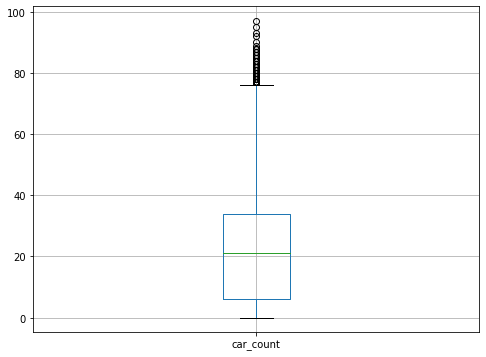

In [65]:
df_2.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`

### Análisis gráfico Experimento #2

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

Para determinar si la medición en la que se registró el mayor valor para `car_count` es un outlayer se puede
representar la evolución de ese día y de otros.

In [58]:
df_2.loc[df_2['car_count'] > 100]

,sensor,datetime,car_count
787793,PM032,2019-11-17 20:00:00,97
1324936,PM032,2019-12-10 09:35:00,95
1391627,PM024,2019-12-13 14:15:00,103
1483650,PM032,2019-12-18 10:50:00,104
1531491,PM032,2019-12-20 18:25:00,93
2172701,PM072,2020-01-28 08:10:00,92


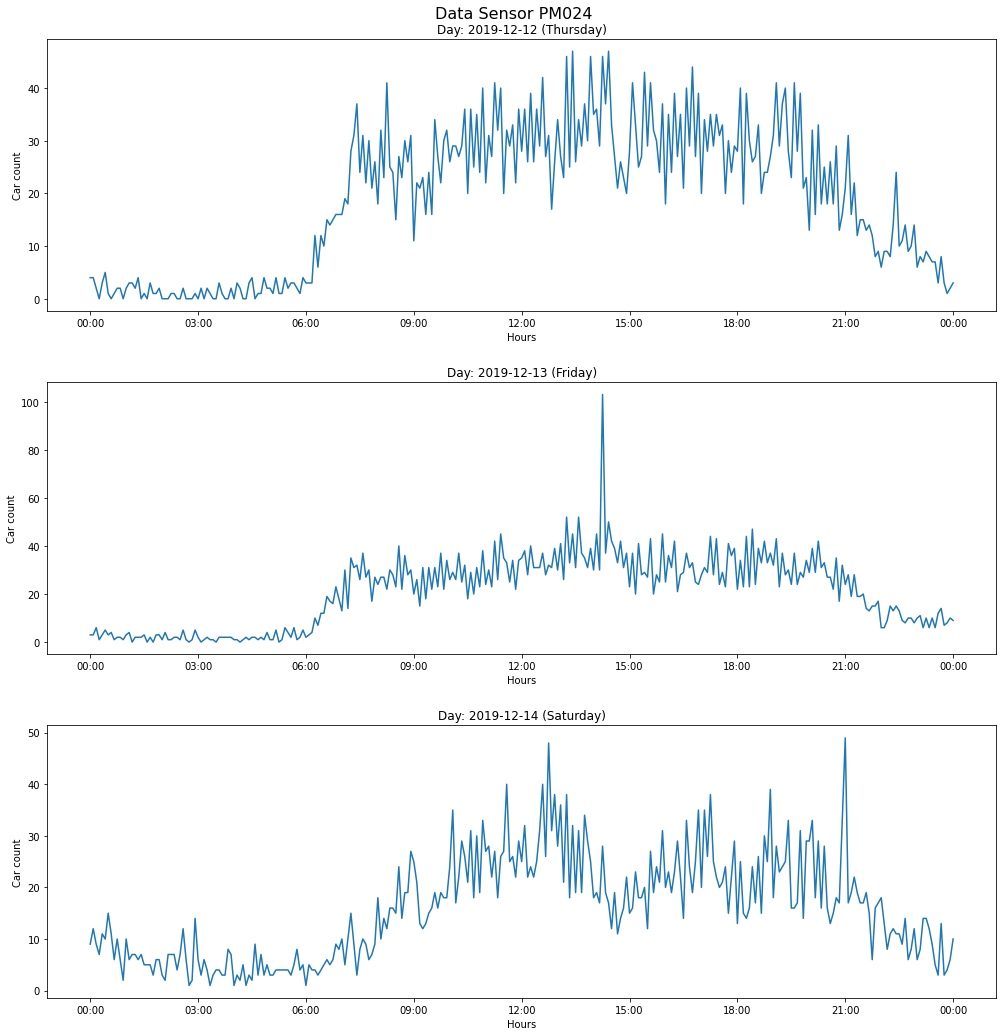

In [56]:
days = pd.date_range(start='2019-12-12', end='2019-12-14', freq='D')
plot_sensors_daily_data(df_orig=df_2, days_list = days, sensor='PM024')

En la gráfica correspondiente al `2019-12-17` se puede observar lo comentado en el anterior experimento. Los sensores
pueden fallar (o no realizar mediciones por labores de mantenimiento), por lo que, en caso de que esto suceda, **las mediciones
de los otros sensores que fueron realizados en ese mismo instante temporal deben ser descartadas.**

*De esto ya se encarga la función que ha sido creada para preparar el dataset.*

Por otra parte, la gráfica correspondiente `2019-12-18`, el día en el que se registró el máximo valor de `car_count`, se
puede observar un pico muy pronunciado. Para tener más claro si se trata de un error en la medición se pueden observar las
mediciones previas y posteriores a ese instante temporal para el sensor `PM032`:

In [60]:
df_2.loc[(df_2['datetime'] >= '2019-12-18 10:30:00') & (df_2['datetime'] <= '2019-12-18 11:00:00') & (df_2['sensor'] == 'PM032')]

,sensor,datetime,car_count
787355,PM032,2019-11-17 19:30:00,34
787428,PM032,2019-11-17 19:35:00,48
787501,PM032,2019-11-17 19:40:00,33
787574,PM032,2019-11-17 19:45:00,31
787647,PM032,2019-11-17 19:50:00,62
787720,PM032,2019-11-17 19:55:00,40
787793,PM032,2019-11-17 20:00:00,97
787866,PM032,2019-11-17 20:05:00,50
787939,PM032,2019-11-17 20:10:00,36
788012,PM032,2019-11-17 20:15:00,32


Observando las mediciones anteriores y posteriores se puede observar que no hay entradas para los 10 minutos anteriores.
**En ocasiones, los sensores se detienen o fallan y al recuperarse insertan como medición el total de coches que pasaron
durante esos minutos que estuvieron fuera de servicio. Este valor es el resultado de un error, por lo que la medición debe
ser eliminada:**

In [155]:
df_2 = df_2[df_2['car_count'] < 100.0]

Para determinar si alguna de las mediciones con mayor cuantía de vehículos (> 90) se trataba de un error se ha seguido un
procedimiento similar. **Finalmente, se ha determinado que ninguna de esas mediciones se trata de un error.**

### Preparación dataset Experimento #2

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [68]:
column_names = ['datetime', 'car_count_PM024', 'car_count_PM030', 'car_count_PM031', 'car_count_PM032', 'label_PM072']
pd.DataFrame(columns = column_names)

,datetime,car_count_PM024,car_count_PM030,car_count_PM031,car_count_PM032,label_PM072


A continuación se utiliza la función para preparar el dataset para el Experimento #2:

In [156]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032']
df_2 = prepare_df(df_2, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función que en el Experimento #1:

In [157]:
df_2 = encode_time(df_2)
df_2.sample()

,car_count_PM024,car_count_PM030,car_count_PM031,car_count_PM032,label_PM072,week_day,hour,min
22449,23,34,18,34,38,4,21,5


#### División del dataset, Separación y Normalización

In [158]:
#Shuffle
df_2=df_2.sample(frac=1).reset_index(drop=True)

n = len(df_2)
train_df_2 = df_2[0:int(n*0.90)]
test_df_2 = df_2[int(n*0.90):]

In [159]:
train_labels = train_df_2.pop('label_PM072')
train_features = train_df_2

test_labels = test_df_2.pop('label_PM072')
test_features = test_df_2

In [160]:
# Se define el scaler
scaler_x = MinMaxScaler(feature_range = (0,1))
#Se adapta a los datos de entrenamiento
input_scaler = scaler_x.fit(train_features)

# Se aplica la normalización a los datos de entrenamiento
train_normed = input_scaler.transform(train_features)
# Se aplica la normalización a los datos de test
test_normed = input_scaler.transform(test_features)

#Se obtienen de nuevos pandas.df
train_features = pd.DataFrame(train_normed, columns = train_features.columns)
test_features = pd.DataFrame(test_normed, columns = test_features.columns)


# Esto es ESTANDARIZACIÓN
#train_mean = train_features.mean()
#train_std = train_features.std()

#train_features = (train_features - train_mean) / train_std
#test_features = (test_features - train_mean) / train_std

In [171]:
train_features

,car_count_PM024,car_count_PM030,car_count_PM031,car_count_PM032,week_day,hour,min
0,0.139241,0.180556,0.088608,0.319588,0.833333,0.260870,0.818182
1,0.012658,0.000000,0.012658,0.010309,0.166667,0.130435,0.000000
2,0.202532,0.291667,0.240506,0.288660,0.833333,0.913043,0.363636
3,0.417722,0.486111,0.468354,0.453608,0.333333,0.521739,0.272727
4,0.215190,0.388889,0.417722,0.412371,0.833333,0.869565,0.909091
...,...,...,...,...,...,...,...
34891,0.037975,0.097222,0.000000,0.030928,0.833333,0.130435,0.727273
34892,0.012658,0.027778,0.025316,0.061856,1.000000,0.304348,0.545455
34893,0.341772,0.444444,0.303797,0.556701,0.333333,0.304348,0.727273
34894,0.025316,0.069444,0.012658,0.041237,0.166667,0.086957,0.090909


#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [181]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dropout(0.2),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [182]:
model = build_and_compile_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 128)               1024      
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)               

In [183]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 7min 45s, sys: 50.6 s, total: 8min 36s
Wall time: 6min 23s


In [185]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
195,48.791424,5.145990,43.975010,4.840219,195
196,48.576336,5.123423,44.117203,4.836342,196
197,48.382725,5.115830,45.117710,4.912596,197
198,48.566837,5.127169,43.541229,4.818595,198
199,48.246128,5.112690,43.808937,4.833653,199


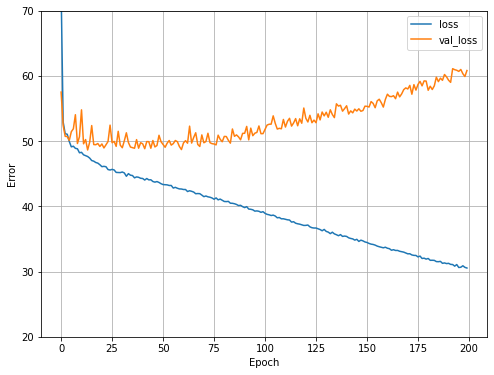

In [132]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


plot_loss(history)


In [ ]:
model.predict(test_features[:10])















## Experimento #3

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #3** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
- `PM076` (Rúa do Horreo - Rotonda Galuresa)
- `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
- `PM079` (Rúa do Horreo - Rotonda Galuresa)

### Análisis dataset Experimento #3

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [65]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079', 'PM072']
df_3 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_3.describe().transpose()

Veamos un boxplot:

<AxesSubplot:>

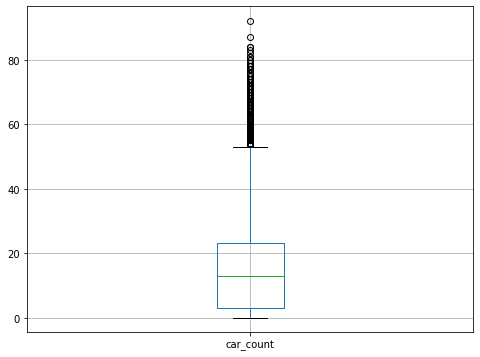

In [88]:
df_3.boxplot(column=['car_count'])

En este boxplot se pueden ver 3 outalyers muy claros. En la siguiente sección se determinará la causa de dichos valores.

### Análisis gráfico Experimento #3

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

A continuación se analizarán las mediciones 'sospechosas' del boxplot anterior:

In [ ]:
df_3.loc[df_3['car_count'] > 100]

Resulta interesante ver que las 3 mediciones se produjeron en el mismo instante temporal.

En la siguiente gráfica se muestra la evolución del día anterior y siguiente al `2019-11-22` para el
sensor `PM079`:

In [ ]:
days = pd.date_range(start='2019-11-21', end='2019-11-23', freq='D')
plot_sensors_daily_data(df_orig=df_3, days_list = days, sensor='PM079')

En la gráfica correspondiente al `2019-11-22` se puede observar lo comentado en el anterior experimento. Al tratarse de
un error en las mediciones estos datos deben ser eliminados del conjunto:

In [66]:
df_3 = df_3[df_3['car_count'] < 100]

El resto de mediciones se encuentran dentro de lo normal

### Preparación dataset Experimento #3

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [67]:
column_names = ['datetime', 'car_count_PM020', 'car_count_PM076', 'car_count_PM077', 'car_count_PM079', 'label_PM072']
pd.DataFrame(columns = column_names)

,datetime,car_count_PM020,car_count_PM076,car_count_PM077,car_count_PM079,label_PM072


A continuación se utiliza la función para preparar el dataset para el Experimento #3:

In [54]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079']
df_3 = prepare_df(df_3, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [68]:
df_3 = encode_time_sin_cos(df_3)
df_3.sample()

,sensor,car_count,hour_sin,hour_cos,wday_sin,wday_cos
23751,PM020,5,0.722364,0.691513,0.974928,-0.222521


#### División del dataset, Separación y Normalización

In [69]:
#Shuffle
df_3=df_3.sample(frac=1).reset_index(drop=True)

n = len(df_3)
train_df_3 = df_3[0:int(n*0.90)]
test_df_3 = df_3[int(n*0.90):]

In [70]:
train_labels = train_df_3.pop('label_PM072')
train_features = train_df_3

test_labels = test_df_3.pop('label_PM072')
test_features = test_df_3

KeyError: 'label_PM072'

In [71]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [81]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(512,
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dropout(0.5),
      layers.Dense(512,
                   activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(512,
                   activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [82]:
model = build_and_compile_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               4608      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

In [83]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 26min 52s, sys: 2min 8s, total: 29min
Wall time: 12min 54s


In [84]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
195,47.192116,5.116413,51.292740,5.510403,195
196,47.295273,5.112293,52.172619,5.706518,196
197,47.056137,5.108710,50.997890,5.510092,197
198,47.340935,5.131436,52.620243,5.672426,198
199,47.412407,5.131588,51.699951,5.662992,199


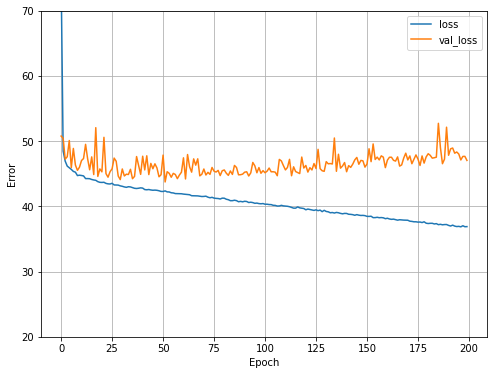

In [63]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)


plot_loss(history)


In [ ]:
model.predict(test_features[:10])

















## Experimento #4

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #4** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t a partir de
las mediciones realizadas en un instante `t-x` por **todos los sensores de la ciudad.**

### Análisis dataset Experimento #4

En este caso se trabaja con todo el dataset, por lo que no es necesario especificar los sensores en concreto:

In [149]:
df_4 = df

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [37]:
df_4.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_count,2904379.0,12.220462,18.023441,0.0,0.0,4.0,19.0,806.0


Veamos un boxplot:

<AxesSubplot:>

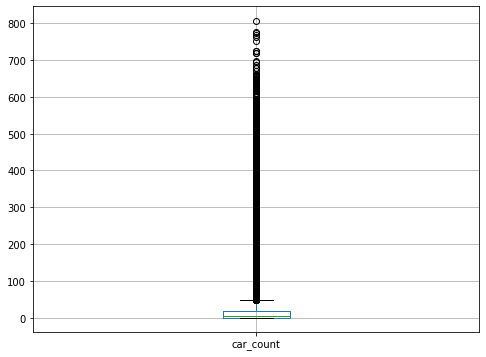

In [38]:
df_4.boxplot(column=['car_count'])

En este boxplot se puede observar que hay una gran cantidad de mediciones que superan los 100 coches en 5 minutos.
Debido a la gran cantidad de mediciones que hay (en torno a 3 millones), resulta imposible realizar un análisis gráfico
como se realizó para los experimentos anteriores.

Por lo experiencia obtenida durante los anteriores experimentos y aplicando
un poco de lógica, se descartarán todas las mediciones que superen un `car_count de 200`. Esto se debe a que en los experimentos
anteriores se pudo concluir que eran outlayers debidos a errores o fallos en el funcionamiento de los sensores. Por otra parte,
un `car_count de 200` implica un flujo de 40 coches por minuto, lo cual en una ciudad como Santiago de Compostela es bastante.
Asimismo, todos los sensores están colocados en vías urbanas en las que hay tan sólo un carril y la velocidad está limitada
a 50km/h (como máximo), por lo que aplicando un poco de sentido común, es imposible que pasen 40 coches por minuto de media.

In [150]:
df_4 = df_4.loc[df_4['car_count'] < 200]

### Preparación dataset Experimento #4

#### Label PM072

A continuación se utiliza la función para preparar el dataset para el Experimento #3:

In [151]:
# Selecciono todos los sensores (sin repetición)
sensors_list = df_4['sensor'].unique()
# PM072 será el label
sensors_list.tolist().remove('PM072')
# Los ordeno por comodidad
sensors_list.sort()
# Preparo el dataset
df_4 = prepare_df(df_4, sensors_list, 'PM072', x = 5)

A partir de la experiencia obtenida en los anteriores experimentos, sabemos que hay sensores que nunca contaron un coche;
es decir, su columna en este nuevo dataframe es todo 0. Como estos datos no aportan nada, dichas columnas deben ser eliminadas:

In [153]:
df_4 = df_4.loc[:, (df_4 != 0).any(axis=0)]

Además, se ha podido observar que algunas columnas tan solo tienen un par de datos distintos de 0; es decir, tan
solo han realizado 2 mediciones de las 36790. Estas columnas también deben ser eliminadas

In [154]:
xx = df_4.loc[:, df_4.columns != 'datetime']
aa = xx.astype(bool).sum(axis=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(aa)

car_count_PM001    24427
car_count_PM002    26229
car_count_PM003     5715
car_count_PM009        2
car_count_PM010    24548
car_count_PM011    28469
car_count_PM013    33414
car_count_PM015    36005
car_count_PM016    35992
car_count_PM017    35318
car_count_PM018    36242
car_count_PM020    33905
car_count_PM021    35488
car_count_PM024    34946
car_count_PM026    35907
car_count_PM028    32930
car_count_PM029    32758
car_count_PM030    35518
car_count_PM031    34367
car_count_PM032    35830
car_count_PM035    35679
car_count_PM036    28380
car_count_PM037    30892
car_count_PM040    34305
car_count_PM043    32789
car_count_PM044    35882
car_count_PM046    34999
car_count_PM047    33620
car_count_PM048    29334
car_count_PM049    34982
car_count_PM050    34719
car_count_PM051    29358
car_count_PM052    35900
car_count_PM053    35477
car_count_PM054    34347
car_count_PM055    35031
car_count_PM056    34650
car_count_PM057    33110
car_count_PM058    34574
car_count_PM059    28354


En esta lista se puede observar que los sensores `PM009`, `PM061`, `PM074` y `PM075` solo han realizado
2 mediciones a lo largo de estos 5 meses.

In [155]:
to_drop = ['car_count_PM009', 'car_count_PM061', 'car_count_PM074', 'car_count_PM075']
df_4 = df_4.drop(to_drop, axis=1)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:


In [156]:
df_4 = encode_time_sin_cos(df_4)
df_4.sample()

NameError: name 'encode_time_sin_cos' is not defined

#### División del dataset, Separación y Normalización